# micrograd

## Imports

In [176]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivatives Review

Calculating the slope, *y*, when *x* is altered by any amount *h*: 
$$y = \lim_{h \to 0}\frac{f(x+h)-f(h)}{h}$$
The derivative is when the *y* = 0.

In [177]:
def f(x):
    return 3*x**2 - 4*x + 5

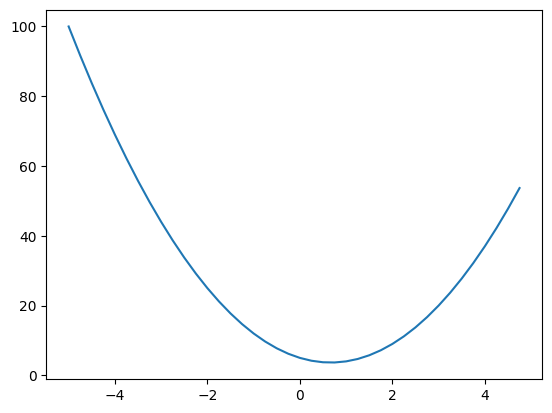

In [178]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [179]:
h = 0.000000001
x = 2/3
print("f(x): ", f(x))
print("f(x+h): ", f(x+h))

(f(x+h) - f(x))/h

f(x):  3.666666666666667
f(x+h):  3.666666666666667


0.0

Let's get more complex and introduce a third input.

In [180]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c

What is the deriviative of *d* with respect to *a*, *b*, and *c*?

In [181]:
h = 0.0001

da1 = a*b + c
da = a + h
da2 = da*b + c

print("da1: ", da1)
print("da2: ", da2)
print("Slope with respect to a: ", (da2 - da1)/h)

db1 = a*b + c
db = b + h
db2 = a*db + c

print("db1: ", db1)
print("db2: ", db2)
print("Slope with respect to b: ", (db2 - db1)/h)

dc1 = a*b + c
dc = c + h
dc2 = a*b + dc

print("dc1: ", dc1)
print("dc2: ", dc2)
print("Slope with respect to c: ", (dc2 - dc1)/h)

da1:  4.0
da2:  3.999699999999999
Slope with respect to a:  -3.000000000010772
db1:  4.0
db2:  4.0002
Slope with respect to b:  2.0000000000042206
dc1:  4.0
dc2:  4.0001
Slope with respect to c:  0.9999999999976694


## Neural Networks Review

### Value Object
In order to properly track which values and operations produce other values - the key ingredient for backpropogation - we need create a Value class.

In [182]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        output = Value(self.data + other.data, (self, other), "+")
        return output

    def __mul__(self, other):
        output = Value(self.data * other.data, (self, other), "*")
        return output

In [183]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
d = a*b; d.label = "d"
e = d + c; e.label = "e"
f = Value(-2.0, label = "f")
L = e * f; L.label = "L"

print("L: ", L)
print("L's children: ", L._prev)

L:  Value(data = -8.0)
L's children:  {Value(data = -2.0), Value(data = 4.0)}


### Backpropogation

In [184]:
from graphviz import Digraph

In [185]:
# Builds a set of all nodes and edges in a graph.
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Creates a box for every value in the graph.
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # If the value is the result of an operation, creates a circle around it.
            dot.node(name = uid + n._op, label = n._op)
            # Connects the operation circle to the value.
            dot.edge(uid + n._op, uid)

    for n1, n2, in edges:
        # Connects one node to the operation circle of another node.
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

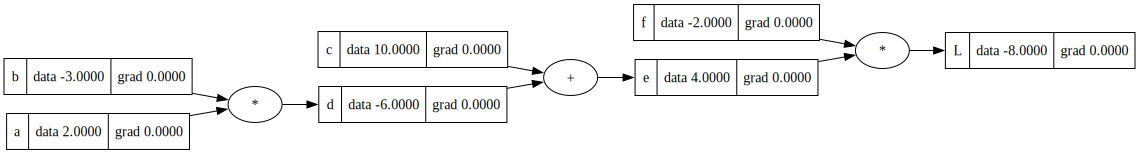

In [186]:
draw_dot(L)

The derivative of *L* with respect to *L* is 1.

The derivative of *L* with respect to *e* is:
$$L = f(x) = e*f$$
$$\frac{dL}{de} = ?$$
$$\frac{dL}{de} = \frac{f(x + h) - f(x)}{h}$$
$$\frac{dL}{de} = \frac{(e + h)*f - e*f}{h}$$
$$\frac{dL}{de} = \frac{e*f + h*f - e*f}{h}$$
$$\frac{dL}{de} = \frac{h*f}{h} = f$$
and therefore the derivative of *L* with respect to *f* is:
$$\frac{dL}{df} = e$$

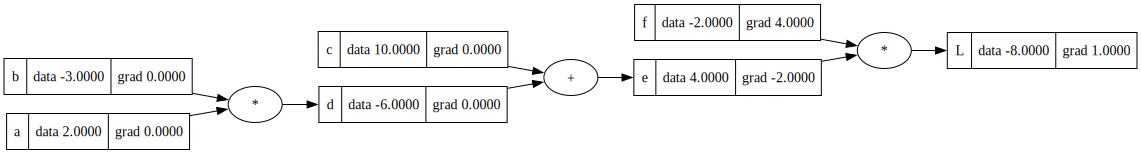

In [187]:
L.grad = 1.0
f.grad = e.data
e.grad = f.data

draw_dot(L)

The derivative of *L* with respect to *c* is more complex, because there's multiple layers in between. But if you know how *c* impacts *e* and you know how *e* impacts *L*, you can combine them together. First calculate the derivative of *e* with respect to *c* and *d*:
$$e = c + d$$
$$\frac{de}{dc} = ?$$
$$\frac{de}{dc} = \frac{f(x + h) - f(x)}{h}$$
$$\frac{de}{dc} = \frac{(c + h) + d - (c + d)}{h}$$
$$\frac{de}{dc} = \frac{h}{h} = 1.0$$
and therefore the derivative of *L* with respect to *d* is also:
$$\frac{de}{dd} = 1.0$$
This is called the **local derivative** because it's isolated from other operations. We still need the derivative of *L* with respect to *c*, which is calculated through the **chain rule**:

*If a car travels fast twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast the man.* - George F. Simmons

With this intuition, we can apply the chain rule to our problem:

$$\frac{dL}{dc} = ?$$
$$\frac{dL}{dc} = \frac{dL}{de} * \frac{de}{dc}$$
$$\frac{dL}{dc} = -2.0 * 1.0 = -2.0$$

So because the plus node's local derivative is always 1, it always routes the derivative of other nodes. The derivative of *L* with respect to *d* then is also the same as *e*.

$$\frac{dL}{dd} = -2.0$$

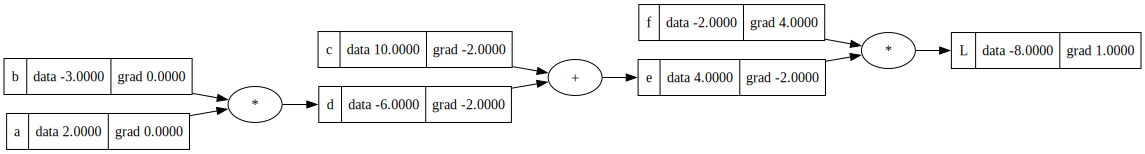

In [188]:
c.grad = e.grad
d.grad = e.grad

draw_dot(L)

We can finish finding the final two nodes, *a*, and *b*, with the chain rule too:

$$\frac{dL}{da} = ?$$
$$\frac{dL}{da} = \frac{dL}{de} * \frac{de}{da}$$
$$\frac{dL}{da} = \frac{dL}{de} * \frac{de}{dd} * \frac{dd}{da}$$
$$\frac{dd}{da} = \frac{f(x + h) - f(x)}{h} = \frac{(a + h)*b - (a*b)}{h} = b$$
$$\frac{dL}{da} = -2.0 * 1.0 * -3.0 = 6.0$$

The derivative of *L* with respect to *b* will therefore be:

$$\frac{dL}{db} = \frac{dL}{de} * \frac{de}{dd} * \frac{dd}{db}$$
$$\frac{dL}{db} = -2.0 * 1.0 * a = -4.0$$

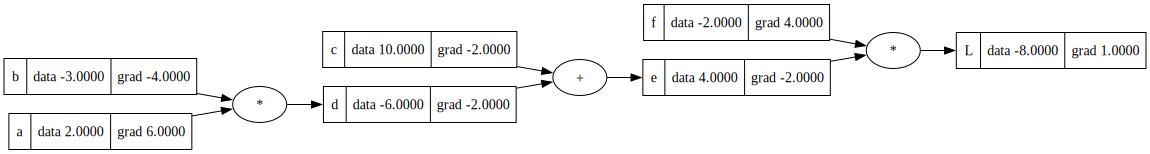

In [189]:
a.grad = 6.0
b.grad = -4.0

draw_dot(L)

We can validate all of the math above by adding a small amount, *h*, to each value and seeing how much *L* changes by.

In [190]:
def lol(n):

    h = 0.001
    
    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    d = a*b; d.label = "d"
    e = d + c; e.label = "e"
    f = Value(-2.0, label = "f")
    L = e * f; L.label = "L"
    L1 = L.data

    nodes = [a, b, c, d, e, f]

    for node in nodes:
        if n == node.label:
            node.data += h

    a = Value(a.data, label = "a")
    b = Value(b.data, label = "b")
    c = Value(c.data, label = "c")
    d = a*b; d.label = "d"
    e = d + c; e.label = "e"
    f = Value(f.data, label = "f")
            
    L = e * f; L.label = "L"
    L2 = L.data

    print((L2 - L1)/h)

In [191]:
lol("b")

-3.9999999999995595


Now, if we want to increase the value of *L*, we need to push each node in the direction of the gradient.

In [192]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a*b
e = d + c
L = e * f

print("L's new value: ", L.data)

L's new value:  -7.286496


### Neuron Backpropogation